<h3>Customer Churn - Wieso gehen Kunden weg? - ANN </h3>

In diesem Abschnitt geht es darum, mit einem ANN herauszufinden, ob Kunden bei bestimmten Bedingungen gehen oder bleiben.

Für das Training wird ein ANN eingesetzt.

>
>Dataset:  https://www.kaggle.com/datasets/blastchar/telco-customer-churn [Letzter Zugriff: 14.06.2024]
>
>Telco Customer Churn - Focused customer retention programs
>
>Siehe auch: https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113 [Letzter Zugriff: 14.06.2024]

In [200]:
# Imports.
import tensorflow as tf
import pandas     as pd
import numpy      as np
import seaborn    as sn

import matplotlib.pyplot as plt

from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import train_test_split

In [153]:
churn_df = pd.read_csv('./data/datasets/telcoc_customer_churn.zip', compression='zip')
churn_df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [154]:
churn_df.shape

(7043, 21)

Data Exploration und Feature Engineering.:

Das Dataset hat 21 Features, die vielleicht nicht alle gleich wichtig sind.

Die Features haben numerische und kategorische Werte. Features, die kategorische Werten haben, können mit On-Hot-Enocde oder Label-Enocder behandelt werden. 

Bei Features mit numerischen Werten können wir Outliers finden und eliminieren.

In [155]:
# Zeige Spalten an.
churn_df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [156]:
# Zeige Datentypen an.
churn_df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Nach dem Betrachten der Features kann festgestellt werden, dass die Spalte mit der KundenID uns keinen wichtigen Informationen liefert, diese können wir löschen.

Zudem ist zu sehen, das numerische Werte als Objekte angegeben sind.

In [157]:
dataset = churn_df.drop(['customerID'], axis="columns")

In [158]:
# Mit .values können sich Werte angeschaut werden => wirklich als int/float hinterlegt? 
# - Features, die numerisch sein sollten, können durch den Namen identifiziert werden
dataset.SeniorCitizen.values

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [159]:
# Hört sich nach einer Zahl an, ist als String hinterlegt.
dataset.TotalCharges.values

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

In [160]:
float(" 6 ")

6.0

In [161]:
# Nutze Lambda und .apply.:
# - Problem:
#    - Es gibt Werte die nicht als Float gecastet werden können.
#dataset['TotalCharges'].apply(lambda x: float(x))

In [162]:
# Alternativ können wir das nutzen.: 
# - Siehe: https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html
# - Werte bei den es Scheitert, werden mit NaN ersetzt => später füllen. 
#  - errors='coerce' => NaN 
pd.to_numeric(dataset['TotalCharges'], errors='coerce')

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

Damit kann auch noch mehr.:

In [163]:
dataset[ pd.to_numeric(dataset['TotalCharges'], errors='coerce').isnull() ] 
# Diese Einträge können wir löschen.

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [164]:
dataset = dataset[dataset['TotalCharges'] != ' ']

In [165]:
dataset.shape

(7032, 20)

Das Feature TotalCharges kann jetzt problemlos in numerische Werte umgewandelt werden.

Felder, die keine Werte oder andere Zeichen enthalten, können auch ersetzt werden.

In [166]:
dataset['TotalCharges'] = pd.to_numeric(dataset['TotalCharges'])
dataset.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

<Axes: xlabel='MonthlyCharges'>

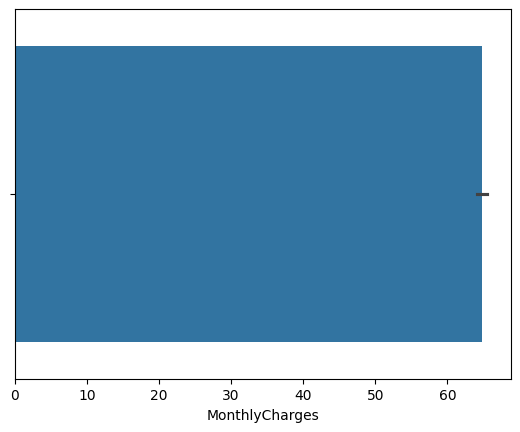

In [167]:
# Outlier mit Boxplot feststellen. 
sn.barplot(data=dataset, x=dataset['MonthlyCharges'])


<Axes: xlabel='Partner', ylabel='count'>

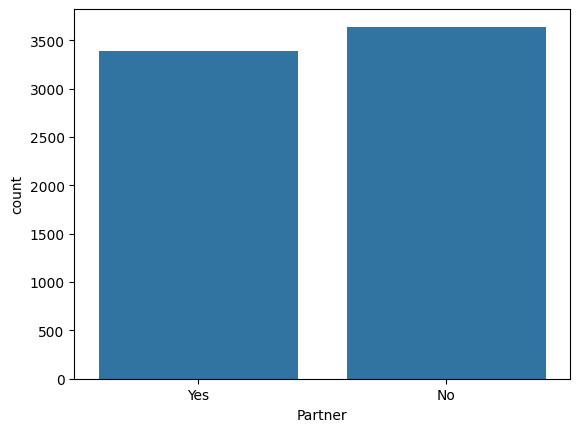

In [168]:
# Kategorische Features können so gezählt werden:
sn.countplot(data=dataset, x=dataset['Partner'])

<Axes: title={'center': 'PhoneService gegen Tenure'}, xlabel='Contract', ylabel='tenure'>

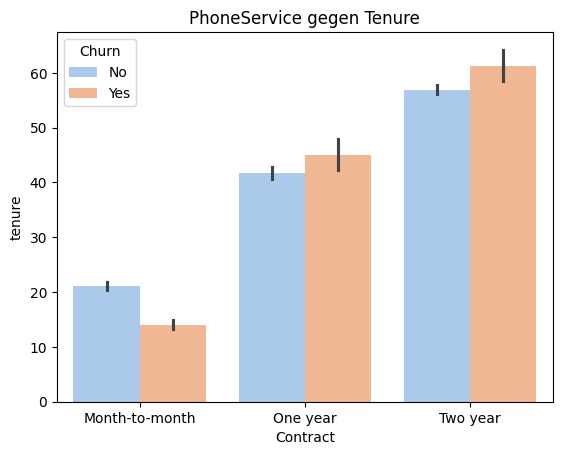

In [169]:
# Plot tenure "wie lange war diese Person dabei".
plt.title("PhoneService gegen Tenure")
plt.xlabel("Contract")
plt.ylabel('tenure')
sn.barplot(data=dataset, x=dataset['Contract'].values, y=dataset['tenure'].values, hue=dataset['Churn'], palette='pastel')
# palette='pastel': sieht angenehmer aus- Geschmackssache.

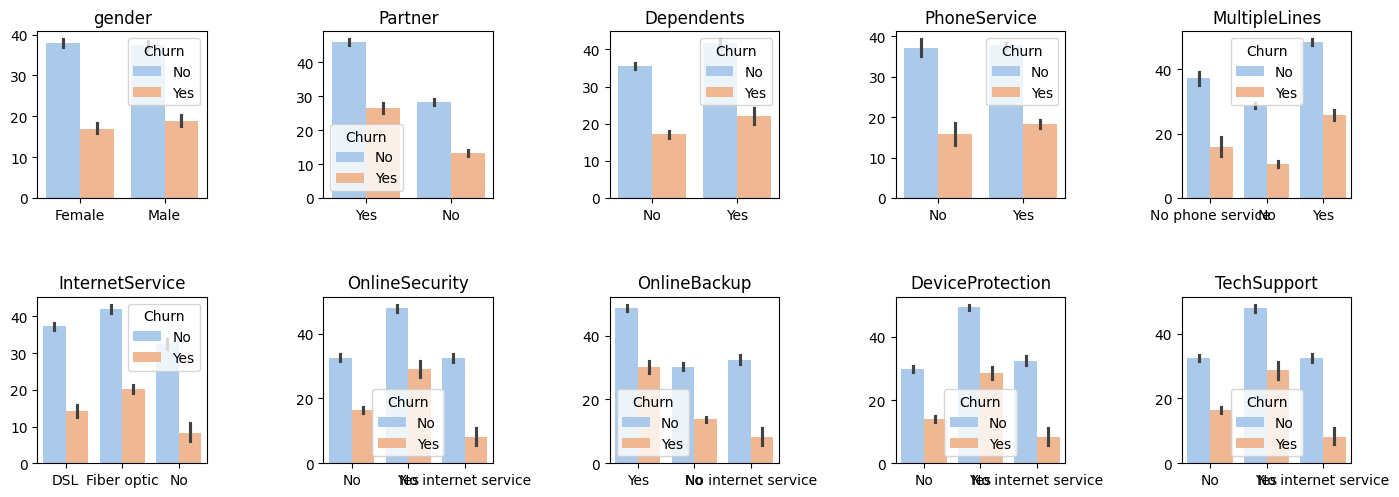

In [170]:
# Mehrere Plots

colums_list = list( dataset.columns )
exclude = ['tenure', 'Churn', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']

#                       y  x
fig, axs = plt.subplots(2,5, figsize=(15, 6), )

fig.tight_layout(pad=5.0)
axs = axs.ravel()

for i in exclude:
    colums_list.remove(i)

for i in range(10): # Ziege einige.
    sn.barplot(data=dataset, x=dataset[colums_list[i]].values, y=dataset['tenure'].values, \
               hue=dataset['Churn'], palette='pastel', ax=axs[i])
  
    axs[i].set_title(colums_list[i])
plt.show()

Viele weitere Visualisierungen sind möglich. 

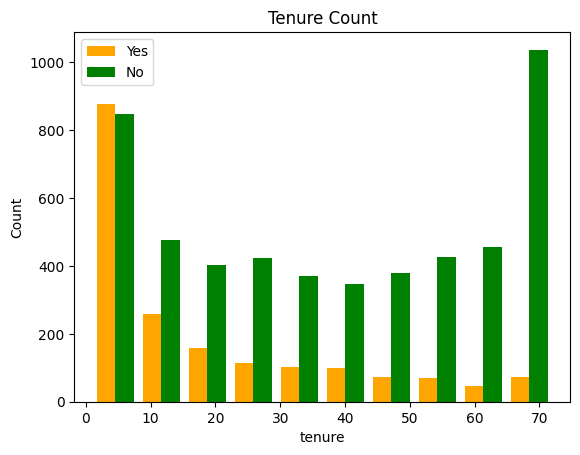

In [171]:
# Ein Histogramm liefert uns auch wichtige Informationen.
# - Plote Kundenanzahl die gehen und bleiben basierend auf tenure
plt.title("Tenure Count")
plt.xlabel('tenure')
plt.ylabel('Count')
plt.hist([ dataset[dataset['Churn']=='Yes'].tenure, dataset[dataset['Churn']=='No'].tenure ], \
        color=['orange', 'green'],  label=['Yes', 'No'])
plt.legend()

Jetzt geht es darum, die kategorischen Werte numerisch zu repräsentieren.

Dafür kann On-Hot Encode und Label Encoding eingesetzt werden. <br>
Bei Werten wie (yes, no), eignet sich On-Hot Encode gut. 

In [172]:
dataset.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [173]:
# Schaue welche unique Werte es gibt.
dataset.Partner.unique()

array(['Yes', 'No'], dtype=object)

In [174]:
# oder auch als Schleife:
# - Man kann einfach durch das Dataframe iterieren. 
for fet in dataset:
    print(fet) # Gibt Features aus, das können wir so nutzen.

gender
SeniorCitizen
Partner
Dependents
tenure
PhoneService
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaperlessBilling
PaymentMethod
MonthlyCharges
TotalCharges
Churn


In [175]:
# Für alle Features
# - Gebe Namen aus, wie viele Werte unique sind, und welche es sind.
# - Nur bei nicht-numerischen Werten.
for fet in dataset:
    if dataset[fet].dtypes=='object':
        print(f"Feature: {fet}, Unique-Count: {dataset[fet].unique().shape[0]}, Values: \n{dataset[fet].unique()} ") 
# - Weitere Ausgaben und Kombinationen sind möglich.

Feature: gender, Unique-Count: 2, Values: 
['Female' 'Male'] 
Feature: Partner, Unique-Count: 2, Values: 
['Yes' 'No'] 
Feature: Dependents, Unique-Count: 2, Values: 
['No' 'Yes'] 
Feature: PhoneService, Unique-Count: 2, Values: 
['No' 'Yes'] 
Feature: MultipleLines, Unique-Count: 3, Values: 
['No phone service' 'No' 'Yes'] 
Feature: InternetService, Unique-Count: 3, Values: 
['DSL' 'Fiber optic' 'No'] 
Feature: OnlineSecurity, Unique-Count: 3, Values: 
['No' 'Yes' 'No internet service'] 
Feature: OnlineBackup, Unique-Count: 3, Values: 
['Yes' 'No' 'No internet service'] 
Feature: DeviceProtection, Unique-Count: 3, Values: 
['No' 'Yes' 'No internet service'] 
Feature: TechSupport, Unique-Count: 3, Values: 
['No' 'Yes' 'No internet service'] 
Feature: StreamingTV, Unique-Count: 3, Values: 
['No' 'Yes' 'No internet service'] 
Feature: StreamingMovies, Unique-Count: 3, Values: 
['No' 'Yes' 'No internet service'] 
Feature: Contract, Unique-Count: 3, Values: 
['Month-to-month' 'One year' 'T

Durch diese Ausgaben ist deutlich zu sehen, welche Werte für das Training eine Rolle spielen könnten bzw. welche Werte wir ersetzen oder löschen können. 

Bei Werten wie ['No' 'Yes' 'No internet service'] können wir ausgehen, das 'No internet service' No bedeutet. So wird die Menge der verschiedenen Werte reduziert und das Dataset wird eindeutiger. 

Um die nötigen Änderungen vorzunehmen, kann eine Lambdaoperation oder eine einfache Ersetzung vorgenommen werden.

In [176]:
# Funktion für das ersetzen.
# - * Nicht an Feature gebunden. 
def replace_val(df:pd.DataFrame, targets:[str], replacements:[str]) -> pd.DataFrame:

    if len(targets) != len(replacements):
        return None

    for target, replacement in zip(targets, replacements):
        df.replace(target, replacement, inplace=True)

    return df

In [177]:
ziel     = ['No internet service', 'No phone service'] 
ersetzen = ['No', 'No']
dataset_new = replace_val(dataset, ziel, ersetzen)

In [183]:
for fet in dataset_new:
    if dataset_new[fet].dtypes=='object':
        print(f"Feature: {fet}, Unique-Count: {dataset_new[fet].unique().shape[0]}, Values: \n{dataset_new[fet].unique()} ") 

Feature: gender, Unique-Count: 2, Values: 
['Female' 'Male'] 
Feature: Partner, Unique-Count: 2, Values: 
['Yes' 'No'] 
Feature: Dependents, Unique-Count: 2, Values: 
['No' 'Yes'] 
Feature: PhoneService, Unique-Count: 2, Values: 
['No' 'Yes'] 
Feature: MultipleLines, Unique-Count: 2, Values: 
['No' 'Yes'] 
Feature: InternetService, Unique-Count: 3, Values: 
['DSL' 'Fiber optic' 'No'] 
Feature: OnlineSecurity, Unique-Count: 2, Values: 
['No' 'Yes'] 
Feature: OnlineBackup, Unique-Count: 2, Values: 
['Yes' 'No'] 
Feature: DeviceProtection, Unique-Count: 2, Values: 
['No' 'Yes'] 
Feature: TechSupport, Unique-Count: 2, Values: 
['No' 'Yes'] 
Feature: StreamingTV, Unique-Count: 2, Values: 
['No' 'Yes'] 
Feature: StreamingMovies, Unique-Count: 2, Values: 
['No' 'Yes'] 
Feature: Contract, Unique-Count: 3, Values: 
['Month-to-month' 'One year' 'Two year'] 
Feature: PaperlessBilling, Unique-Count: 2, Values: 
['Yes' 'No'] 
Feature: PaymentMethod, Unique-Count: 4, Values: 
['Electronic check' 'Ma

Durch diese Veränderung ist das Encoding simpler und liefert einen höheren Mehrwert. 
- Es können viele Vorgänge automatisiert werden.

Jetzt kann der Rest codiert werden. Dafür kann wieder optional eine Funktion angelegt werden.

In [191]:
# Z. B. so.:
# - So können noch andere Werte ersetzt oder andere Operationen zusätzlich durchgeführt werden.
def pandas_OnHot(df:pd.DataFrame, targets:[str]) -> pd.DataFrame:

    dummies_df = pd.get_dummies(df[targets], drop_first=True, dtype='int') # Erstelle Dummies, lösche erste Spalte.
    df1 = df.drop(targets, axis="columns")                          # Lösche Targets aus df.
    df2 = pd.concat([df1, dummies_df], axis="columns")          # Füge Dummies ein.
    # Sonstiges ...
    return df2

In [192]:
ziel = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', \
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn', 'PaymentMethod',\
       'Contract']
dataset_with_dummies = pandas_OnHot(dataset_new, ziel)

In [193]:
for fet in dataset_with_dummies:
    print(f"Feature: {fet}, Unique-Count: {dataset_with_dummies[fet].unique().shape[0]},\
    Values: \n{dataset_with_dummies[fet].unique()} ") 

Feature: SeniorCitizen, Unique-Count: 2,    Values: 
[0 1] 
Feature: tenure, Unique-Count: 72,    Values: 
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39] 
Feature: MonthlyCharges, Unique-Count: 1584,    Values: 
[29.85 56.95 53.85 ... 63.1  44.2  78.7 ] 
Feature: TotalCharges, Unique-Count: 6530,    Values: 
[  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ] 
Feature: gender_Male, Unique-Count: 2,    Values: 
[0 1] 
Feature: Partner_Yes, Unique-Count: 2,    Values: 
[1 0] 
Feature: Dependents_Yes, Unique-Count: 2,    Values: 
[0 1] 
Feature: PhoneService_Yes, Unique-Count: 2,    Values: 
[0 1] 
Feature: MultipleLines_Yes, Unique-Count: 2,    Values: 
[0 1] 
Feature: InternetService_Fiber optic, Unique-Count: 2,    Values: 
[0 1] 
Feature: InternetService_No, Unique-Count: 2,    Values: 
[0 1] 
Feature: OnlineSecu

In [194]:
# Zeige alle Typen nochmal an. 
# - Es kann auch Encoding von [0, 1, 2, ...] verwendet werden => Label Encoding
#   und Ordinal-Encoding, wenn der Rank eine Rolle spielt.
dataset_with_dummies.dtypes

SeniorCitizen                              int64
tenure                                     int64
MonthlyCharges                           float64
TotalCharges                             float64
gender_Male                                int32
Partner_Yes                                int32
Dependents_Yes                             int32
PhoneService_Yes                           int32
MultipleLines_Yes                          int32
InternetService_Fiber optic                int32
InternetService_No                         int32
OnlineSecurity_Yes                         int32
OnlineBackup_Yes                           int32
DeviceProtection_Yes                       int32
TechSupport_Yes                            int32
StreamingTV_Yes                            int32
StreamingMovies_Yes                        int32
PaperlessBilling_Yes                       int32
Churn_Yes                                  int32
PaymentMethod_Credit card (automatic)      int32
PaymentMethod_Electr

In [196]:
dataset_with_dummies.head(6)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,...,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,PaperlessBilling_Yes,Churn_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_One year,Contract_Two year
0,0,1,29.85,29.85,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,0,34,56.95,1889.50,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
2,0,2,53.85,108.15,1,0,0,1,0,0,...,0,0,0,1,1,0,0,1,0,0
3,0,45,42.30,1840.75,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,2,70.70,151.65,0,0,0,1,0,1,...,0,0,0,1,1,0,1,0,0,0
5,0,8,99.65,820.50,0,0,0,1,1,1,...,0,1,1,1,1,0,1,0,0,0


Bevor das eigentliche Training losgeht, müssen die Daten skaliert werden.

In [199]:
# Erstelle Scaler, skaliert Werte in den Bereich 0 bis 1.
scaler = MinMaxScaler()

dataset_with_dummies[ ['tenure', 'MonthlyCharges', 'TotalCharges'] ] = \
         scaler.fit_transform(dataset_with_dummies[ ['tenure', 'MonthlyCharges', 'TotalCharges'] ])

dataset_with_dummies.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,...,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,PaperlessBilling_Yes,Churn_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_One year,Contract_Two year
0,0,0.000000,0.115423,0.001275,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,0,0.464789,0.385075,0.215867,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
2,0,0.014085,0.354229,0.010310,1,0,0,1,0,0,...,0,0,0,1,1,0,0,1,0,0
3,0,0.619718,0.239303,0.210241,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,0.014085,0.521891,0.015330,0,0,0,1,0,1,...,0,0,0,1,1,0,1,0,0,0


In [214]:
# Teile Dataset in Train- und Testdaten auf. 
X_train, X_test, y_train, y_test = train_test_split(\
            dataset_with_dummies.drop(['Churn_Yes'], axis="columns"), dataset_with_dummies['Churn_Yes'], test_size=.20)

In [215]:
X_train.shape

(5625, 23)

Jetzt kann das Training losgehen. 

In [225]:
# Model.
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=15, input_shape=(23,), activation='leaky_relu' ),  # L1: Input Neuronen,  + L2: Dense
    tf.keras.layers.Dense(10, activation='leaky_relu'),  # L3: Dense
    tf.keras.layers.Dense(1, activation='sigmoid')       # L4: Dense
])

tb_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/churn_ann/leaky_relu", histogram_freq=1)

model.compile(
    optimizer= 'adam',
    loss     = 'binary_crossentropy',
    metrics  = ['accuracy'])  # Da wir 0 und 1 als Output haben.


In [226]:
model.fit(X_train, y_train, epochs=15, callbacks=[tb_callback])

Epoch 1/15
176/176 [==============================] - 1s 1ms/step - loss: 0.5579 - accuracy: 0.6924
Epoch 2/15
176/176 [==============================] - 0s 1ms/step - loss: 0.4408 - accuracy: 0.7884
Epoch 3/15
176/176 [==============================] - 0s 1ms/step - loss: 0.4253 - accuracy: 0.7975
Epoch 4/15
176/176 [==============================] - 0s 1ms/step - loss: 0.4193 - accuracy: 0.7995
Epoch 5/15
176/176 [==============================] - 0s 1ms/step - loss: 0.4153 - accuracy: 0.8016
Epoch 6/15
176/176 [==============================] - 0s 1ms/step - loss: 0.4134 - accuracy: 0.8060
Epoch 7/15
176/176 [==============================] - 0s 1ms/step - loss: 0.4128 - accuracy: 0.8032
Epoch 8/15
176/176 [==============================] - 0s 1ms/step - loss: 0.4110 - accuracy: 0.8048
Epoch 9/15
176/176 [==============================] - 0s 1ms/step - loss: 0.4099 - accuracy: 0.8052
Epoch 10/15
176/176 [==============================] - 0s 1ms/step - loss: 0.4085 - accuracy: 0.8059

In [213]:
# Model Testen.
model.evaluate(X_test, y_test)

55/55 [==============================] - 0s 704us/step - loss: 0.4623 - accuracy: 0.7856


[0.4623105227947235, 0.7855517864227295]

In [218]:
model.predict(X_test)

44/44 [==============================] - 0s 605us/step


array([[0.11977867],
       [0.1603721 ],
       [0.00429565],
       ...,
       [0.5811807 ],
       [0.49930185],
       [0.42095348]], dtype=float32)

In [221]:
# Wandle zahlen in 1 und 0 um.
# - In Python einfach umsetzbar. 
preds = [ 0 if x<0.5 else 1 for x in model.predict(X_test) ]

44/44 [==============================] - 0s 651us/step


Jetzt können wir eine Heat-Map erstellen wie sonst auch immer.

In [227]:
tf.math.confusion_matrix(labels=y_test, predictions=preds)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[925, 109],
       [184, 189]])>

Text(33.22222222222222, 0.5, 'Truth')

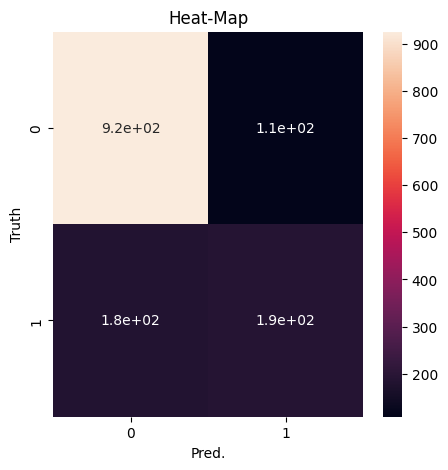

In [230]:
# Mit Matplotlib und Seaborn visualisieren.
# - Hier ohne Klassennamen.
heatmap = tf.math.confusion_matrix(labels=y_test, predictions=preds)
plt.figure(figsize=(5, 5))
sn.heatmap(heatmap, annot=True)
plt.title("Heat-Map")
plt.xlabel("Pred.")
plt.ylabel("Truth")